In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
from func import calc_vpin, imbalance
from data_load import load_data
from data_processing import transform_buy_sell_volume
from data_visualization import visualize_price_wealth, visualize_position_wealth

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from scipy.stats.stats import pearsonr
from sklearn.metrics import confusion_matrix

In [4]:
# Đường dẫn tới thư mục cần kiểm tra
folder_path = "req_files"
# Kiểm tra nếu thư mục chưa tồn tại thì tạo mới
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Đã tạo thư mục: {folder_path}")
else:
    print(f"Thư mục '{folder_path}' đã tồn tại.")

Thư mục 'req_files' đã tồn tại.


In [5]:
df={}; sec_trades = {}
sym = ['STB', 'SAB','MWG', 'VCB','TCB']

In [6]:
## Load data
data_tick = load_data(folder="tick")
data_orderbook = load_data(folder="orderbook")

In [7]:
# Transform data
for s in sym:
    data = data_tick[s].copy()
    data.rename(columns = {"Gia KL": "PRICE", "KL": "SIZE"}, inplace = True)
    data.set_index("Date", inplace = True)
    data = data.resample("T").agg({
            'SIZE': 'sum',  # Cột volume tính tổng
            'PRICE': 'mean'    # Cột price tính trung bình
        })
    data.dropna(how = "any", inplace = True)
    data.to_csv(f"req_files/{s}price.csv")
    sec_trades[s] = data

In [8]:
# Set volume
volume = {}
for key, val in sec_trades.items():
    volume[key] = int(val['SIZE'].resample("D").sum().mean()/50) # Sum của từng ngày, rồi lấy mean, rồi chia 50
volume


{'STB': 5324, 'SAB': 197, 'MWG': 2364, 'VCB': 490, 'TCB': 5012}

$$
V_{\tau}^B = \sum_{i = t(\tau - 1) + 1}^{t(\tau)} V_i \cdot Z\left(\frac{P_i - P_{i-1}}{\sigma_{\Delta P}}\right)
$$

$$
V_{\tau}^S = \sum_{i = t(\tau - 1) + 1}^{t(\tau)} V_i \cdot \left[ 1 - Z\left(\frac{P_i - P_{i-1}}{\sigma_{\Delta P}}\right) \right] = V - V_{\tau}^B
$$

$$
VPIN = \frac{\alpha \mu}{\alpha \mu + 2\varepsilon} \approx \frac{\sum_{\tau=1}^n \left| V_{\tau}^S - V_{\tau}^B \right|}{nV}.
$$


In [9]:
# Cal vpin
for s in sym:
    print('Calculating VPIN')
    df[s] = calc_vpin(sec_trades[s],volume[s],50)
    df[s].to_csv(f"req_files/{s}VPIN.csv",index = True)
    print(s+' '+str(df[s].shape))

Calculating VPIN
STB (2700, 4)
Calculating VPIN
SAB (2709, 4)
Calculating VPIN
MWG (2700, 4)
Calculating VPIN
VCB (2700, 4)
Calculating VPIN
TCB (2700, 4)


In [11]:

fig = px.line(df["STB"], x=df["STB"].index, y='VPIN', markers=False)
fig.update_traces(connectgaps=False)  # Không nối các khoảng trống
fig.show()


In [12]:

fig = px.line(df["STB"], x=df["STB"].index, y='CDF', markers=False)
fig.update_traces(connectgaps=False)  # Không nối các khoảng trống
fig.show()


In [ ]:
# Tạo figure
fig = go.Figure()

# Thêm đường CDF
fig.add_trace(go.Scatter(
    x=df["STB"].index, 
    y=df["STB"]["CDF"], 
    mode='lines', 
    name='CDF', 
    line=dict(color='blue'),
    connectgaps=False  # Không nối khoảng trống
))

# Thêm đường VPIN với trục y thứ 2
fig.add_trace(go.Scatter(
    x=df["STB"].index, 
    y=df["STB"]["VPIN"], 
    mode='lines', 
    name='VPIN', 
    line=dict(color='orange'),
    yaxis='y2',
    connectgaps=False  # Không nối khoảng trống
))

# Cấu hình layout với hai trục y
fig.update_layout(
    title="CDF vs VPIN",
    xaxis=dict(title="Time"),
    yaxis=dict(title="CDF", tickfont=dict(color="blue")),  
    yaxis2=dict(
        title="VPIN",
        tickfont=dict(color="orange"),
        overlaying="y",
        side="right"
    ),
    legend=dict(x=1.1, y=1),
)

# Hiển thị biểu đồ
fig.show()


In [ ]:

## Tạo avg df, với từng cột chứa phân vị (giá trị từ 0 đến 1) của các giá trị trong cột VPIN của từng stock
metric = 'CDF'
avg = pd.DataFrame()
for stock, frame in df.items():
    print(avg.shape)
    frame_cleaned = frame[[metric]].reset_index().drop_duplicates('Time', keep='last').set_index('Time')
    avg = avg.join(frame_cleaned.rename(columns={metric: f'{metric}_{stock}'}), how='outer')

avg = avg.dropna(how='all').ffill()
avg.to_csv('req_files/CDF.csv')


(0, 0)
(2032, 1)
(2995, 2)
(4106, 3)
(4784, 4)


In [ ]:
# Tạo fields tổng quát hơn
fields = list(avg.columns)
fields.append("Time")
fields

['CDF_STB', 'CDF_SAB', 'CDF_MWG', 'CDF_VCB', 'CDF_TCB', 'Time']

### Mean Correlation at time
$$
\text{Mean Correlation at time } t = \frac{\sum_{i=1}^{n} \sum_{j=1}^{n} r_{ij}(t)}{n^2}
$$


In [ ]:
df = pd.read_csv('req_files/CDF.csv',parse_dates=['Time'],index_col=[0],usecols = fields)
rolling_pariwise_corr = df.rolling(window=50).corr()

thres = pd.DataFrame()
thres['AvgCorrAssets'] = rolling_pariwise_corr.groupby(by=['Time']).sum().sum(axis=1)/((len(fields)-1)**2)
thres.shape
thres.to_csv('req_files/AvgCorrAssets.csv')
thres.shape

(5204, 1)

In [ ]:
STB = transform_buy_sell_volume(data_dict=data_orderbook, key1 = "STB")

In [ ]:
STB.rename(columns = {
    "Gia_Mua": "BID",
    "KL_mua": "BIDSIZ",
    "Gia_Ban": "ASK",
    "KL_ban": "ASKSIZ"
    }, inplace = True)
STB.set_index("Date", inplace=True)
STB.shape

(7526, 5)

In [ ]:
quote_imb=imbalance(STB)
quote_imb.to_csv('req_files/imbalance.csv')
quote_imb.shape

(6824, 1)

In [ ]:
sec_trades = data_tick["STB"]
print('File read complete')

File read complete


## Applying Theory Based and ML Based Trading Strategies

In [ ]:
df_corr_assets = pd.read_csv('req_files/AvgCorrAssets.csv',parse_dates=['Time'],index_col='Time')
print(df_corr_assets.shape)
df_vpin = pd.read_csv('req_files/STBVPIN.csv',parse_dates=['Time'],usecols=['Time','CDF'],index_col='Time')
print(df_vpin.shape)
df_quote_imb = pd.read_csv('req_files/imbalance.csv',parse_dates=['Date'],index_col='Date')
df_quote_imb.index.name = 'Time'
print(df_quote_imb.shape)
df_price = pd.read_csv('req_files/STBprice.csv')[["Date", "PRICE"]]
df_price = df_price.set_index('Date').rename_axis('Time')
print(df_price.shape)


(5204, 1)
(2700, 1)
(6824, 1)
(6802, 1)


In [ ]:
frames_info = [df_corr_assets, df_vpin, df_quote_imb, df_price]
total_df = pd.DataFrame()
for _df in frames_info:
    _df = _df[[_df.columns[0]]].reset_index().drop_duplicates(subset='Time', keep='last')
    _df["Time"]=pd.to_datetime(_df["Time"])
    _df.set_index('Time', inplace = True)
    total_df = total_df.merge(_df[[_df.columns[0]]],left_index=True,right_index=True,how='outer')
    print (total_df.shape)
total_df = total_df.dropna(axis=0,how='all').fillna(method='ffill').fillna(method='bfill')
total_df = total_df.dropna(how='any')
print (total_df.shape)

(5204, 1)
(5220, 2)
(7126, 3)
(7340, 4)
(7340, 4)


In [ ]:
total_df.to_csv('req_files/data_qlearner.csv')

In [ ]:
df = total_df.copy()
df.head()

AvgCorrAssets       CDF  quote_imb      PRICE
Time                                                              
2024-09-23 13:00:00            0.0  0.049415  -391120.0  30.941667
2024-09-23 13:01:00            0.0  0.049415   -68310.0  30.901724
2024-09-23 13:02:00            0.0  0.049415  -623890.0  30.900000
2024-09-23 13:04:00            0.0  0.049415  -124940.0  30.900000
2024-09-23 13:05:00            0.0  0.049415  -249740.0  30.900000

In [ ]:
df["returns"] = df["PRICE"].pct_change().shift(-1)
df = df.replace([np.inf, -np.inf], np.nan).ffill().iloc[:-1]
df.index = pd.to_datetime(df.index)
df = pd.concat([
    df.loc[df.index.dayofweek < 5].between_time("09:00", "11:30"),
    df.loc[df.index.dayofweek < 5].between_time("13:00", "15:00")
])

df.to_csv("new_data.csv")

savg = df[["AvgCorrAssets", "quote_imb"]].rolling(window=100).mean()
sstd = df[["AvgCorrAssets", "quote_imb"]].rolling(window=100).std()

In [ ]:
zcorras = ((df["AvgCorrAssets"] - savg["AvgCorrAssets"]) / sstd["AvgCorrAssets"]).clip(-3, 3)
zimb = ((df["quote_imb"] - savg["quote_imb"]) / sstd["quote_imb"]).clip(-3, 3)

df_trading = pd.DataFrame({
    "price": df["PRICE"].iloc[100:],
    "cdf": df["CDF"].iloc[100:],
    "zcorras": zcorras.iloc[100:],
    "zimb": zimb.iloc[100:],
    "returns": df["returns"].iloc[100:],
    "Time": df.index[100:]
}).set_index("Time").sort_index()

df_trading.to_csv("req_files/final.csv")

In [ ]:
print(df_trading["price"].describe())
print(df_trading["price"].isna().sum())  # Đếm số NaN


count    7239.000000
mean       34.013206
std         1.039858
min        30.817308
25%        33.450000
50%        33.850000
75%        34.992949
max        36.394000
Name: price, dtype: float64
0


In [ ]:
df_trading.head()

price       cdf   zcorras      zimb       returns
Time                                                                      
2024-09-23 13:00:00  30.941667  0.049415 -2.208937 -2.639316 -1.290898e-03
2024-09-23 13:01:00  30.901724  0.049415 -2.223019 -1.051183 -5.579423e-05
2024-09-23 13:02:00  30.900000  0.049415 -2.248204 -3.000000  2.220446e-16
2024-09-23 13:04:00  30.900000  0.049415 -2.287442 -1.187206  0.000000e+00
2024-09-23 13:05:00  30.900000  0.049415 -2.335284 -1.707088 -1.110223e-16

In [ ]:
fig = px.line(df_trading, x=df_trading.index, y='price', markers=False)
fig.update_traces(connectgaps=False)  # Không nối các khoảng trống
fig.show()


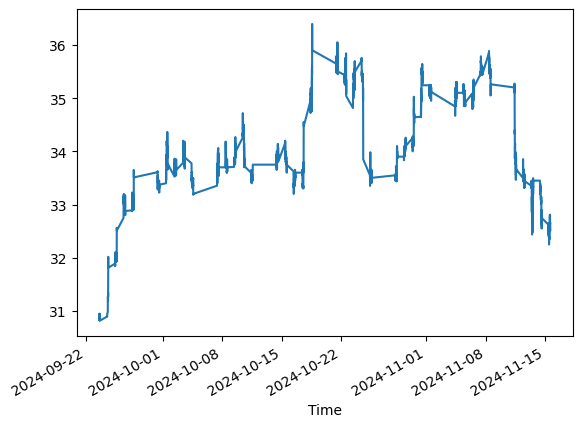

In [ ]:
df_trading["price"].plot()
plt.show()

In [ ]:
pos_lst = []
position, bcount, scount = 0, 0, 0

for index, row in df_trading.iterrows():
    if row["cdf"] > 0.6 and abs(row["zcorras"]) > 2:
        if row["zimb"] > 1.5:
            position = max(0, position + 0.1)
            bcount = 10
        elif row["zimb"] < -1.5:
            position = min(0, position - 0.1)
            scount = 10
    
    if position > 0:
        bcount -= 1
        if bcount == 0:
            position = 0
    elif position < 0:
        scount -= 1
        if scount == 0:
            position = 0
    
    pos_lst.append({
        "Time": index,
        "position": position,
        "returns": row["returns"],
        "price": row["price"]
    })

pos = pd.DataFrame(pos_lst).set_index("Time")
pos["wealth"] = (1 + pos["returns"] * pos["position"]).cumprod()

In [ ]:
pos.head()

position       returns      price  wealth
Time                                                          
2024-09-23 13:00:00       0.0 -1.290898e-03  30.941667     1.0
2024-09-23 13:01:00       0.0 -5.579423e-05  30.901724     1.0
2024-09-23 13:02:00       0.0  2.220446e-16  30.900000     1.0
2024-09-23 13:04:00       0.0  0.000000e+00  30.900000     1.0
2024-09-23 13:05:00       0.0 -1.110223e-16  30.900000     1.0

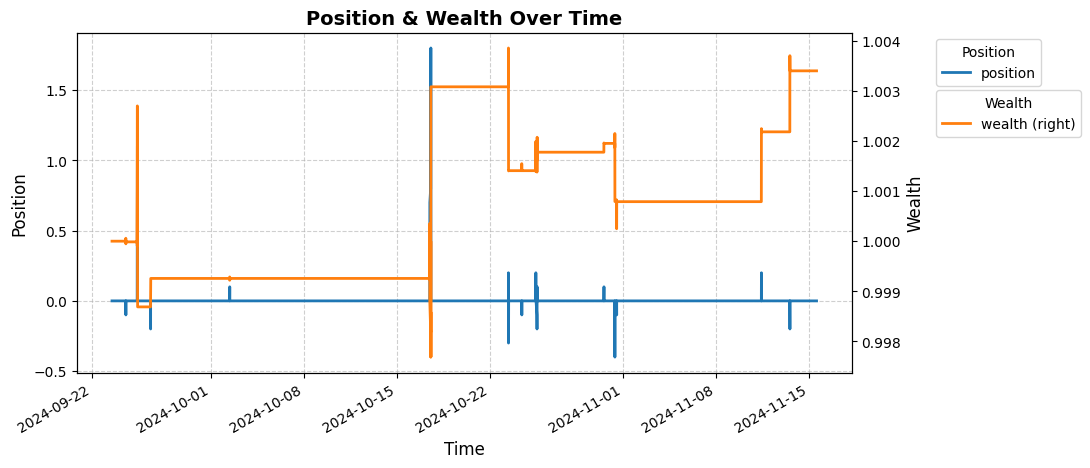

In [ ]:
visualize_position_wealth(pos)

### Applying ML Classification Based Strategies

In [ ]:
df= df_trading.copy()
df=df[df['zcorras'].notnull()]
number = int(df.shape[0]*0.7)

In [ ]:
X = df[['cdf','zcorras','zimb']]
y=(df['returns']>0).astype(int)

# Split the data into training/testing sets
df_X_train = X[:number]
df_X_test = X[number:]

# Split the targets into training/testing sets
df_y_train = y[:number]
df_y_test = y[number:]

In [ ]:
score=[]
pos=None
classifiers = [
    KNeighborsClassifier(4),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=0.25, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=4),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

for cla,name in zip(classifiers,names): 
    try:
        clf=cla
        clf.fit(df_X_train, df_y_train)
        score.append(accuracy_score(df_y_test,clf.predict(df_X_test)))
        position=((clf.predict_proba(df_X_test))*[-0.05,0.05]).sum(axis=1)
        print(classification_report(df_y_test, clf.predict(df_X_test)))
        wealth=(1+df['returns'][number:]*position).cumprod()
        if(pos is None):
            pos=pd.DataFrame({'returns':df['returns'][number:], name:wealth,'price':df['price'][number:],'Time':df.index[number:]}).set_index('Time')
        else:
            pos[name]=position
        visualize_price_wealth(pos, name)
    except Exception as e:
        print("Failed: ",cla, name)
        print("ERROR: ", e)
        pass

              precision    recall  f1-score   support

           0       0.65      0.82      0.73      1423
           1       0.34      0.18      0.23       749

    accuracy                           0.60      2172
   macro avg       0.50      0.50      0.48      2172
weighted avg       0.55      0.60      0.56      2172



              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1423
           1       0.00      0.00      0.00       749

    accuracy                           0.66      2172
   macro avg       0.33      0.50      0.40      2172
weighted avg       0.43      0.66      0.52      2172



              precision    recall  f1-score   support

           0       0.66      0.99      0.79      1423
           1       0.43      0.02      0.04       749

    accuracy                           0.65      2172
   macro avg       0.54      0.50      0.41      2172
weighted avg       0.58      0.65      0.53      2172



              precision    recall  f1-score   support

           0       0.65      0.93      0.77      1423
           1       0.33      0.06      0.10       749

    accuracy                           0.63      2172
   macro avg       0.49      0.50      0.44      2172
weighted avg       0.54      0.63      0.54      2172



              precision    recall  f1-score   support

           0       0.66      0.94      0.77      1423
           1       0.37      0.06      0.11       749

    accuracy                           0.64      2172
   macro avg       0.51      0.50      0.44      2172
weighted avg       0.56      0.64      0.54      2172



              precision    recall  f1-score   support

           0       0.66      0.99      0.79      1423
           1       0.36      0.01      0.01       749

    accuracy                           0.65      2172
   macro avg       0.51      0.50      0.40      2172
weighted avg       0.55      0.65      0.52      2172



              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1423
           1       0.00      0.00      0.00       749

    accuracy                           0.66      2172
   macro avg       0.33      0.50      0.40      2172
weighted avg       0.43      0.66      0.52      2172



              precision    recall  f1-score   support

           0       0.65      0.95      0.77      1423
           1       0.34      0.05      0.09       749

    accuracy                           0.64      2172
   macro avg       0.50      0.50      0.43      2172
weighted avg       0.55      0.64      0.54      2172



              precision    recall  f1-score   support

           0       0.66      0.94      0.77      1423
           1       0.35      0.06      0.10       749

    accuracy                           0.64      2172
   macro avg       0.50      0.50      0.44      2172
weighted avg       0.55      0.64      0.54      2172



In [ ]:
params = {'n_neighbors': [3, 5, 7, 9]}
grid = GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(df_X_train, df_y_train)
best_knn = grid.best_estimator_
print("best knn: ", best_knn)
y_pred = best_knn.predict(df_X_test)
print("Accuracy:", accuracy_score(df_y_test, y_pred))
print("Classification Report:\n", classification_report(df_y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(df_y_test, y_pred))

best knn:  KNeighborsClassifier(n_neighbors=9)
Accuracy: 0.5561694290976059
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.72      0.68      1423
           1       0.31      0.24      0.28       749

    accuracy                           0.56      2172
   macro avg       0.48      0.48      0.48      2172
weighted avg       0.53      0.56      0.54      2172

Confusion Matrix:
 [[1025  398]
 [ 566  183]]


In [ ]:
score=[]
pos=None
classifiers = [
    KNeighborsClassifier(4),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=0.25, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=4),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

for cla,name in zip(classifiers,names): 
    try:
        clf=cla
        clf.fit(df_X_train, df_y_train)
        score.append(accuracy_score(df_y_test,clf.predict(df_X_test)))
        # position=((clf.predict_proba(df_X_test))*[-0.05,0.05]).sum(axis=1)
        proba = clf.predict_proba(df_X_test)
        position = np.where(proba[:, 1] > 0.6, 0.05, np.where(proba[:, 0] > 0.6, -0.05, 0))
        print(classification_report(df_y_test, clf.predict(df_X_test)))
        wealth=(1+df['returns'][number:]*position).cumprod()
        if(pos is None):
            pos=pd.DataFrame({'returns':df['returns'][number:], name:wealth,'price':df['price'][number:],'Time':df.index[number:]}).set_index('Time')
        else:
            pos[name]=position
        visualize_price_wealth(pos, name)
    except Exception as e:
        print("Failed: ",cla, name)
        print("ERROR: ", e)
        pass

              precision    recall  f1-score   support

           0       0.65      0.82      0.73      1423
           1       0.34      0.18      0.23       749

    accuracy                           0.60      2172
   macro avg       0.50      0.50      0.48      2172
weighted avg       0.55      0.60      0.56      2172



              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1423
           1       0.00      0.00      0.00       749

    accuracy                           0.66      2172
   macro avg       0.33      0.50      0.40      2172
weighted avg       0.43      0.66      0.52      2172



              precision    recall  f1-score   support

           0       0.66      0.99      0.79      1423
           1       0.43      0.02      0.04       749

    accuracy                           0.65      2172
   macro avg       0.54      0.50      0.41      2172
weighted avg       0.58      0.65      0.53      2172



              precision    recall  f1-score   support

           0       0.65      0.93      0.77      1423
           1       0.33      0.06      0.10       749

    accuracy                           0.63      2172
   macro avg       0.49      0.50      0.44      2172
weighted avg       0.54      0.63      0.54      2172



              precision    recall  f1-score   support

           0       0.66      0.96      0.78      1423
           1       0.37      0.05      0.08       749

    accuracy                           0.64      2172
   macro avg       0.52      0.50      0.43      2172
weighted avg       0.56      0.64      0.54      2172



              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1423
           1       0.00      0.00      0.00       749

    accuracy                           0.66      2172
   macro avg       0.33      0.50      0.40      2172
weighted avg       0.43      0.66      0.52      2172



              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1423
           1       0.00      0.00      0.00       749

    accuracy                           0.66      2172
   macro avg       0.33      0.50      0.40      2172
weighted avg       0.43      0.66      0.52      2172



              precision    recall  f1-score   support

           0       0.65      0.95      0.77      1423
           1       0.34      0.05      0.09       749

    accuracy                           0.64      2172
   macro avg       0.50      0.50      0.43      2172
weighted avg       0.55      0.64      0.54      2172



              precision    recall  f1-score   support

           0       0.66      0.94      0.77      1423
           1       0.35      0.06      0.10       749

    accuracy                           0.64      2172
   macro avg       0.50      0.50      0.44      2172
weighted avg       0.55      0.64      0.54      2172



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

def run_knn_strategy(X_train, y_train, X_test, y_test, df, number, name='KNN', visualize=True):
    """
    Huấn luyện và đánh giá mô hình KNN tốt nhất, trả về DataFrame với wealth và position.

    Parameters:
        X_train, y_train: Tập huấn luyện
        X_test, y_test: Tập kiểm tra
        df: DataFrame gốc có cột 'returns' và 'price'
        number: Offset để slice df['returns'][number:]
        name: Tên mô hình cho biểu đồ
        visualize: Có hiển thị đồ thị không

    Returns:
        result_df: DataFrame với wealth, position, returns, price
        best_knn: Mô hình tốt nhất tìm được
    """

    # 1. Grid Search KNN
    params = {'n_neighbors': [3, 5, 7, 9]}
    grid = GridSearchCV(KNeighborsClassifier(), params, cv=5)
    grid.fit(X_train, y_train)
    best_knn = grid.best_estimator_

    # 2. Dự đoán
    y_pred = best_knn.predict(X_test)
    print("Best KNN:", best_knn)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # 3. Tính position từ xác suất
    proba = best_knn.predict_proba(X_test)
    position = (proba * [-0.05, 0.05]).sum(axis=1)

    # 4. Tính wealth
    wealth = (1 + df['returns'][number:] * position).cumprod()

    # 5. Kết hợp vào DataFrame
    result_df = pd.DataFrame({
        'returns': df['returns'][number:],
        'price': df['price'][number:],
        'position': position,
        name: wealth,
        'Time': df.index[number:]
    }).set_index('Time')

    # 6. Vẽ biểu đồ nếu muốn
    if visualize and 'visualize_price_wealth' in globals():
        visualize_price_wealth(result_df, name)

    return result_df, best_knn


In [ ]:
result_df, best_knn_model = run_knn_strategy(df_X_train, df_y_train, df_X_test, df_y_test, df, number)


Best KNN: KNeighborsClassifier(n_neighbors=9)
Accuracy: 0.5561694290976059
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.72      0.68      1423
           1       0.31      0.24      0.28       749

    accuracy                           0.56      2172
   macro avg       0.48      0.48      0.48      2172
weighted avg       0.53      0.56      0.54      2172

